In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/data/GAN/clean-normal.zip > /dev/null

In [ ]:
path = glob.glob("./clean-normal/*.jpg")
images =[]
for file in tqdm(path):
    img = plt.imread(file)
    img = img[30:-50] / 255.
    img = img * 2. - 1. # reshape and rescale for tahn activation layer
    images.append(img)
X_train = np.asarray(images)

100%|██████████| 7302/7302 [00:20<00:00, 350.68it/s]


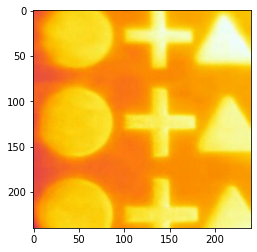

In [ ]:
plt.imshow((X_train[7000]  + 1. )/ 2.)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def plot_multiple_images(images, n_cols=None):
    images = (images + 1.) / 2. 
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for X_batch in tqdm(dataset):
            X_batch = tf.cast(X_batch, tf.float32)
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 4)
        plt.show()

In [ ]:
batch_size = 12
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(15 * 15 * 512, input_shape=[codings_size]),
    keras.layers.Reshape([15, 15, 512]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="tanh")
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=[240, 240, 3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)), 
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)), 
    keras.layers.Conv2D(512, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)), 
    keras.layers.Flatten(),
    keras.layers.Dense(5000, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 115200)            11635200  
                                                                 
 reshape (Reshape)           (None, 15, 15, 512)       0         
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 512)      2048      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 30, 30, 256)      3277056   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 64)      4864      
                                                                 
 dropout (Dropout)           (None, 120, 120, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 128)       204928    
                                                                 
 dropout_1 (Dropout)         (None, 60, 60, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 256)       819456    
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 512)       3277312   
                                                                 
 flatten (Flatten)           (None, 115200)           

Epoch 1/50


100%|██████████| 608/608 [33:49<00:00,  3.34s/it]


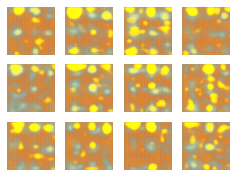

Epoch 2/50


100%|██████████| 608/608 [33:33<00:00,  3.31s/it]


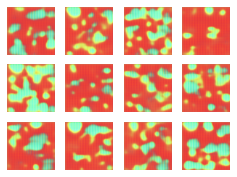

Epoch 3/50


100%|██████████| 608/608 [34:59<00:00,  3.45s/it]


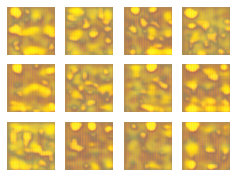

Epoch 4/50


100%|██████████| 608/608 [35:36<00:00,  3.51s/it]


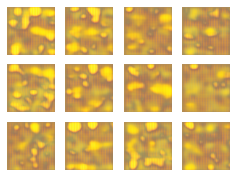

Epoch 5/50


100%|██████████| 608/608 [36:26<00:00,  3.60s/it]


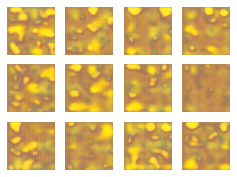

Epoch 6/50


100%|██████████| 608/608 [36:40<00:00,  3.62s/it]


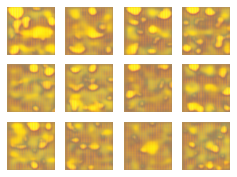

Epoch 7/50


100%|██████████| 608/608 [36:11<00:00,  3.57s/it]


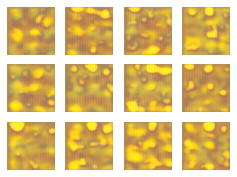

Epoch 8/50


100%|██████████| 608/608 [35:32<00:00,  3.51s/it]


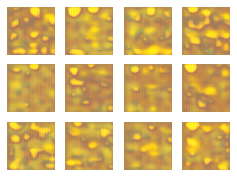

Epoch 9/50


100%|██████████| 608/608 [35:53<00:00,  3.54s/it]


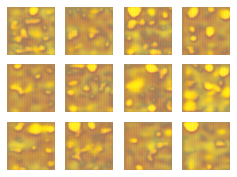

Epoch 10/50


100%|██████████| 608/608 [36:35<00:00,  3.61s/it]


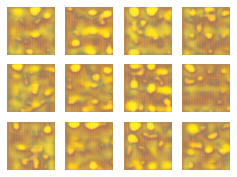

Epoch 11/50


100%|██████████| 608/608 [35:47<00:00,  3.53s/it]


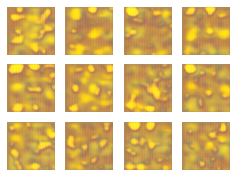

Epoch 12/50


100%|██████████| 608/608 [36:05<00:00,  3.56s/it]


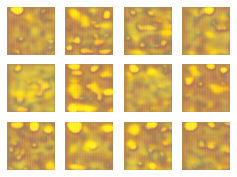

Epoch 13/50


100%|██████████| 608/608 [35:51<00:00,  3.54s/it]


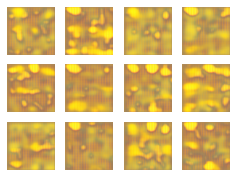

Epoch 14/50


100%|██████████| 608/608 [35:45<00:00,  3.53s/it]


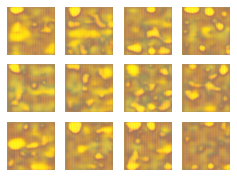

Epoch 15/50


100%|██████████| 608/608 [36:11<00:00,  3.57s/it]


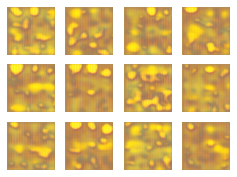

Epoch 16/50


100%|██████████| 608/608 [34:56<00:00,  3.45s/it]


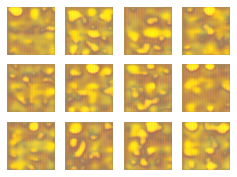

Epoch 17/50


100%|██████████| 608/608 [35:01<00:00,  3.46s/it]


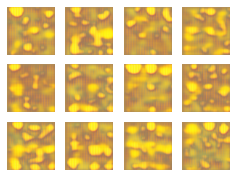

Epoch 18/50


100%|██████████| 608/608 [34:21<00:00,  3.39s/it]


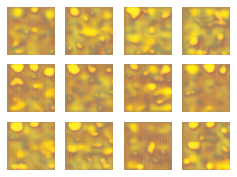

Epoch 19/50


100%|██████████| 608/608 [34:01<00:00,  3.36s/it]


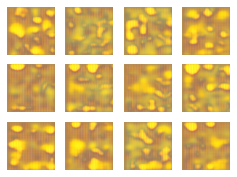

Epoch 20/50


100%|██████████| 608/608 [34:14<00:00,  3.38s/it]


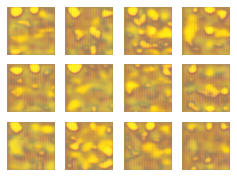

Epoch 21/50


100%|██████████| 608/608 [35:25<00:00,  3.50s/it]


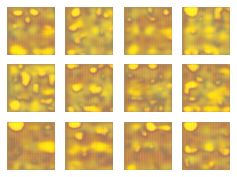

Epoch 22/50


  0%|          | 0/608 [00:00<?, ?it/s]

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

In [ ]:
discriminator.save("./drive/MyDrive/models/GAN/1_discriminator.hdf5")
generator.save("./drive/MyDrive/models/GAN/1_generator.hdf5")
gan.save("./drive/MyDrive/models/GAN/1_gan.hdf5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

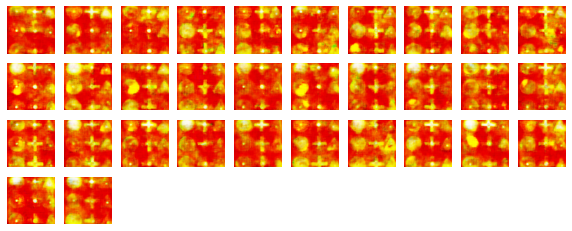

In [ ]:
model = keras.models.load_model("./drive/MyDrive/models/GAN/1_generator.hdf5")
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = model(noise)
plot_multiple_images(generated_images, 10)